# Handling time
Many datasets have timestamps, and pandas is awesome at manipulating such data:
* it can represent periods (such as 2016Q3) and frequencies (such as "monthly"),
* it can convert periods to actual timestamps, and *vice versa*,
* it can resample data and aggregate values any way you like,
* it can handle timezones.

## Time range
Let's start by creating a time series using `pd.date_range()`. This returns a `DatetimeIndex` containing one datetime per hour for 12 hours starting on October 29th 2016 at 5:30pm.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dates = pd.date_range("2016/10/29 5:30pm", periods=12, freq="H")
dates

DatetimeIndex(['2016-10-29 17:30:00', '2016-10-29 18:30:00',
               '2016-10-29 19:30:00', '2016-10-29 20:30:00',
               '2016-10-29 21:30:00', '2016-10-29 22:30:00',
               '2016-10-29 23:30:00', '2016-10-30 00:30:00',
               '2016-10-30 01:30:00', '2016-10-30 02:30:00',
               '2016-10-30 03:30:00', '2016-10-30 04:30:00'],
              dtype='datetime64[ns]', freq='H')

This `DatetimeIndex` may be used as an index in a `Series`:

In [3]:
temperatures = [4.4, 5.1, 6.1, 6.2, 6.1, 6.1, 5.7, 5.2, 4.7, 4.1, 3.9, 3.5]
temp_series = pd.Series(temperatures, dates)
temp_series

2016-10-29 17:30:00    4.4
2016-10-29 18:30:00    5.1
2016-10-29 19:30:00    6.1
2016-10-29 20:30:00    6.2
2016-10-29 21:30:00    6.1
2016-10-29 22:30:00    6.1
2016-10-29 23:30:00    5.7
2016-10-30 00:30:00    5.2
2016-10-30 01:30:00    4.7
2016-10-30 02:30:00    4.1
2016-10-30 03:30:00    3.9
2016-10-30 04:30:00    3.5
Freq: H, dtype: float64

Let's plot this series:

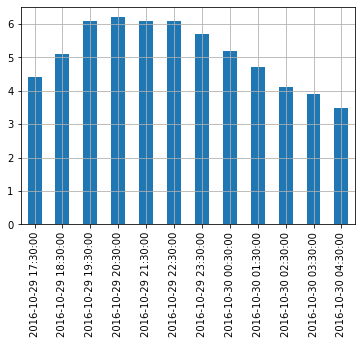

In [4]:
temp_series.plot(kind="bar")

plt.grid(True)
plt.show()

## Resampling
Pandas lets us resample a time series very simply. Just call the `resample()` method and specify a new frequency:

In [5]:
temp_series_freq_2H = temp_series.resample("2H")
temp_series_freq_2H

The resampling operation is actually a deferred operation, which is why we did not get a `Series` object, but a `DatetimeIndexResampler` object instead. To actually perform the resampling operation, we can simply call the `mean()` method: Pandas will compute the mean of every pair of consecutive hours:

In [6]:
temp_series_freq_2H = temp_series_freq_2H.mean()

Let's plot the result:

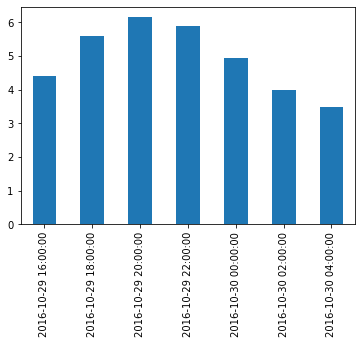

In [7]:
temp_series_freq_2H.plot(kind="bar")
plt.show()

Note how the values have automatically been aggregated into 2-hour periods. If we look at the 6-8pm period, for example, we had a value of `5.1` at 6:30pm, and `6.1` at 7:30pm. After resampling, we just have one value of `5.6`, which is the mean of `5.1` and `6.1`. Rather than computing the mean, we could have used any other aggregation function, for example we can decide to keep the minimum value of each period:

In [8]:
temp_series_freq_2H = temp_series.resample("2H").min()
temp_series_freq_2H

2016-10-29 16:00:00    4.4
2016-10-29 18:00:00    5.1
2016-10-29 20:00:00    6.1
2016-10-29 22:00:00    5.7
2016-10-30 00:00:00    4.7
2016-10-30 02:00:00    3.9
2016-10-30 04:00:00    3.5
Freq: 2H, dtype: float64

Or, equivalently, we could use the `apply()` method instead:

In [9]:
temp_series_freq_2H = temp_series.resample("2H").apply(np.min)
temp_series_freq_2H

2016-10-29 16:00:00    4.4
2016-10-29 18:00:00    5.1
2016-10-29 20:00:00    6.1
2016-10-29 22:00:00    5.7
2016-10-30 00:00:00    4.7
2016-10-30 02:00:00    3.9
2016-10-30 04:00:00    3.5
Freq: 2H, dtype: float64

## Upsampling and interpolation
This was an example of downsampling. We can also upsample (ie. increase the frequency), but this creates holes in our data:

In [10]:
temp_series_freq_15min = temp_series.resample("15Min").mean()
temp_series_freq_15min.head(n=10)  # `head` displays the top n values

2016-10-29 17:30:00    4.4
2016-10-29 17:45:00    NaN
2016-10-29 18:00:00    NaN
2016-10-29 18:15:00    NaN
2016-10-29 18:30:00    5.1
2016-10-29 18:45:00    NaN
2016-10-29 19:00:00    NaN
2016-10-29 19:15:00    NaN
2016-10-29 19:30:00    6.1
2016-10-29 19:45:00    NaN
Freq: 15T, dtype: float64

One solution is to fill the gaps by interpolating. We just call the `interpolate()` method. The default is to use linear interpolation, but we can also select another method, such as cubic interpolation:

In [11]:
temp_series_freq_15min = temp_series.resample("15Min").interpolate(method="cubic")
temp_series_freq_15min.head(n=10)

2016-10-29 17:30:00    4.400000
2016-10-29 17:45:00    4.452911
2016-10-29 18:00:00    4.605113
2016-10-29 18:15:00    4.829758
2016-10-29 18:30:00    5.100000
2016-10-29 18:45:00    5.388992
2016-10-29 19:00:00    5.669887
2016-10-29 19:15:00    5.915839
2016-10-29 19:30:00    6.100000
2016-10-29 19:45:00    6.203621
Freq: 15T, dtype: float64

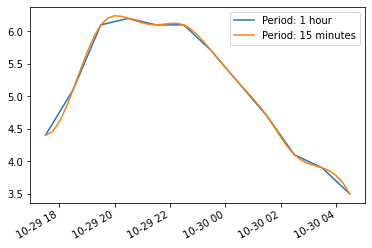

In [12]:
temp_series.plot(label="Period: 1 hour")
temp_series_freq_15min.plot(label="Period: 15 minutes")
plt.legend()
plt.show()

## Timezones
By default datetimes are *naive*: they are not aware of timezones, so 2016-10-30 02:30 might mean October 30th 2016 at 2:30am in Paris or in New York. We can make datetimes timezone *aware* by calling the `tz_localize()` method:

In [13]:
temp_series_ny = temp_series.tz_localize("America/New_York")
temp_series_ny

2016-10-29 17:30:00-04:00    4.4
2016-10-29 18:30:00-04:00    5.1
2016-10-29 19:30:00-04:00    6.1
2016-10-29 20:30:00-04:00    6.2
2016-10-29 21:30:00-04:00    6.1
2016-10-29 22:30:00-04:00    6.1
2016-10-29 23:30:00-04:00    5.7
2016-10-30 00:30:00-04:00    5.2
2016-10-30 01:30:00-04:00    4.7
2016-10-30 02:30:00-04:00    4.1
2016-10-30 03:30:00-04:00    3.9
2016-10-30 04:30:00-04:00    3.5
dtype: float64

Note that `-04:00` is now appended to all the datetimes. This means that these datetimes refer to [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) - 4 hours.

We can convert these datetimes to Paris time like this:

In [14]:
temp_series_paris = temp_series_ny.tz_convert("Europe/Paris")
temp_series_paris

2016-10-29 23:30:00+02:00    4.4
2016-10-30 00:30:00+02:00    5.1
2016-10-30 01:30:00+02:00    6.1
2016-10-30 02:30:00+02:00    6.2
2016-10-30 02:30:00+01:00    6.1
2016-10-30 03:30:00+01:00    6.1
2016-10-30 04:30:00+01:00    5.7
2016-10-30 05:30:00+01:00    5.2
2016-10-30 06:30:00+01:00    4.7
2016-10-30 07:30:00+01:00    4.1
2016-10-30 08:30:00+01:00    3.9
2016-10-30 09:30:00+01:00    3.5
dtype: float64

You may have noticed that the UTC offset changes from `+02:00` to `+01:00`: this is because France switches to winter time at 3am that particular night (time goes back to 2am). Notice that 2:30am occurs twice! Let's go back to a naive representation (if you log some data hourly using local time, without storing the timezone, you might get something like this):

In [15]:
temp_series_paris_naive = temp_series_paris.tz_localize(None)
temp_series_paris_naive

2016-10-29 23:30:00    4.4
2016-10-30 00:30:00    5.1
2016-10-30 01:30:00    6.1
2016-10-30 02:30:00    6.2
2016-10-30 02:30:00    6.1
2016-10-30 03:30:00    6.1
2016-10-30 04:30:00    5.7
2016-10-30 05:30:00    5.2
2016-10-30 06:30:00    4.7
2016-10-30 07:30:00    4.1
2016-10-30 08:30:00    3.9
2016-10-30 09:30:00    3.5
dtype: float64

Now `02:30` is really ambiguous. If we try to localize these naive datetimes to the Paris timezone, we get an error:

In [16]:
try:
    temp_series_paris_naive.tz_localize("Europe/Paris")
except Exception as e:
    print(type(e))
    print(e)

<class 'pytz.exceptions.AmbiguousTimeError'>
Cannot infer dst time from 2016-10-30 02:30:00, try using the 'ambiguous' argument


Fortunately using the `ambiguous` argument we can tell pandas to infer the right DST (Daylight Saving Time) based on the order of the ambiguous timestamps:

In [17]:
temp_series_paris_naive.tz_localize("Europe/Paris", ambiguous="infer")

2016-10-29 23:30:00+02:00    4.4
2016-10-30 00:30:00+02:00    5.1
2016-10-30 01:30:00+02:00    6.1
2016-10-30 02:30:00+02:00    6.2
2016-10-30 02:30:00+01:00    6.1
2016-10-30 03:30:00+01:00    6.1
2016-10-30 04:30:00+01:00    5.7
2016-10-30 05:30:00+01:00    5.2
2016-10-30 06:30:00+01:00    4.7
2016-10-30 07:30:00+01:00    4.1
2016-10-30 08:30:00+01:00    3.9
2016-10-30 09:30:00+01:00    3.5
dtype: float64

## Periods
The `pd.period_range()` function returns a `PeriodIndex` instead of a `DatetimeIndex`. For example, let's get all quarters in 2016 and 2017:

In [18]:
quarters = pd.period_range("2016Q1", periods=8, freq="Q")
quarters

PeriodIndex(['2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4'],
            dtype='period[Q-DEC]')

Adding a number `N` to a `PeriodIndex` shifts the periods by `N` times the `PeriodIndex`'s frequency:

In [19]:
quarters + 3

PeriodIndex(['2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1',
             '2018Q2', '2018Q3'],
            dtype='period[Q-DEC]')

The `asfreq()` method lets us change the frequency of the `PeriodIndex`. All periods are lengthened or shortened accordingly. For example, let's convert all the quarterly periods to monthly periods (zooming in):

In [20]:
quarters.asfreq("M")

PeriodIndex(['2016-03', '2016-06', '2016-09', '2016-12', '2017-03', '2017-06',
             '2017-09', '2017-12'],
            dtype='period[M]')

By default, the `asfreq` zooms on the end of each period. We can tell it to zoom on the start of each period instead:

In [21]:
quarters.asfreq("M", how="start")

PeriodIndex(['2016-01', '2016-04', '2016-07', '2016-10', '2017-01', '2017-04',
             '2017-07', '2017-10'],
            dtype='period[M]')

And we can zoom out:

In [22]:
quarters.asfreq("A")

PeriodIndex(['2016', '2016', '2016', '2016', '2017', '2017', '2017', '2017'], dtype='period[A-DEC]')

Of course we can create a `Series` with a `PeriodIndex`:

In [23]:
quarterly_revenue = pd.Series([300, 320, 290, 390, 320, 360, 310, 410], index=quarters)
quarterly_revenue

2016Q1    300
2016Q2    320
2016Q3    290
2016Q4    390
2017Q1    320
2017Q2    360
2017Q3    310
2017Q4    410
Freq: Q-DEC, dtype: int64

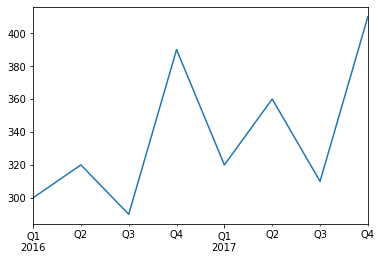

In [24]:
quarterly_revenue.plot(kind="line")
plt.show()

We can convert periods to timestamps by calling `to_timestamp`. By default this will give us the first day of each period, but by setting `how` and `freq`, we can get the last hour of each period:

In [25]:
last_hours = quarterly_revenue.to_timestamp(how="end", freq="H")
last_hours

2016-03-31 23:59:59.999999999    300
2016-06-30 23:59:59.999999999    320
2016-09-30 23:59:59.999999999    290
2016-12-31 23:59:59.999999999    390
2017-03-31 23:59:59.999999999    320
2017-06-30 23:59:59.999999999    360
2017-09-30 23:59:59.999999999    310
2017-12-31 23:59:59.999999999    410
dtype: int64

And back to periods by calling `to_period`:

In [26]:
last_hours.to_period()

2016Q1    300
2016Q2    320
2016Q3    290
2016Q4    390
2017Q1    320
2017Q2    360
2017Q3    310
2017Q4    410
Freq: Q-DEC, dtype: int64

Pandas also provides many other time-related functions that we recommend you check out in the [documentation](http://pandas.pydata.org/pandas-docs/stable/timeseries.html). To whet your appetite, here is one way to get the last business day of each month in 2016, at 9am:

In [27]:
months_2016 = pd.period_range("2016", periods=12, freq="M")
one_day_after_last_days = months_2016.asfreq("D") + 1
last_bdays = one_day_after_last_days.to_timestamp() - pd.tseries.offsets.BDay()
last_bdays.to_period("H") + 9

PeriodIndex(['2016-01-29 09:00', '2016-02-29 09:00', '2016-03-31 09:00',
             '2016-04-29 09:00', '2016-05-31 09:00', '2016-06-30 09:00',
             '2016-07-29 09:00', '2016-08-31 09:00', '2016-09-30 09:00',
             '2016-10-31 09:00', '2016-11-30 09:00', '2016-12-30 09:00'],
            dtype='period[H]')

# What next?
As you probably noticed by now, pandas is quite a large library with *many* features. Although we went through the most important features, there is still a lot to discover. Probably the best way to learn more is to get your hands dirty with some real-life data. It is also a good idea to go through pandas' excellent [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html), in particular the [Cookbook](http://pandas.pydata.org/pandas-docs/stable/cookbook.html).

## Additional References

* [Pandas cheatsheet](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)